<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Fourmethod/notebooks/Our_SBI_method_on_LV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet numpyro dm-haiku==0.0.5 optax

In [ ]:
!pip install git+https://github.com/Justinezgh/SBI-Diff-Simulator.git#@u/EiffL/Infra

In [ ]:
!pip install chainconsumer

In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
%pylab inline
import arviz as az
az.style.use("arviz-darkgrid")

In [6]:
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpyro
from numpyro.handlers import seed, trace, condition
from functools import partial

In [7]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [8]:
from sbids.tasks import lotka_volterra, get_samples_and_scores
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP

In [9]:
from chainconsumer import ChainConsumer

In [10]:
# truth 
key = jax.random.PRNGKey(0)
lokta_volterra_10 = partial(lotka_volterra, ts=jnp.linspace(0,18.9,5))
lvcond = condition(lokta_volterra_10, {'z':jnp.array([30.0, 1.0])})
(log_probs0, samples0), scores = get_samples_and_scores(lvcond, key, batch_size=1)
observation0 = samples0['y']
observation = np.reshape(observation0, (-1,10), order='F')
truth0 = samples0['theta']

In [11]:
# create data train 
key = jax.random.PRNGKey(10)
(log_probs, samples), score = get_samples_and_scores(lvcond, key, batch_size=5e5)
batch = samples['y']
batch = np.reshape(batch, (-1,10), order='F')
mu = samples['theta']


if (batch > 500).any() == True:
  idx = jnp.where(batch > 500)[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

if jnp.isnan(batch).any() == True:
  idx = jnp.where(jnp.isnan(batch))[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

In [ ]:
# normalize data 
#mu2 = jnp.log(mu)
#scale_theta = (jnp.std(mu2, axis =0)/0.04)
#shift_theta = jnp.mean(mu2/scale_theta, axis = 0)-0.5

#scale_reg = (jnp.std(batch, axis =0)/0.02)
#shift_reg = jnp.mean(batch/scale_reg, axis = 0)-0.5

#transformation_params = tfb.Chain([tfb.Exp(),tfb.Scale(scale_theta),tfb.Shift(shift_theta)])
#transformation_x = tfb.Chain([tfb.Scale(scale_reg),tfb.Shift(shift_reg)])

#normalized_p = transformation_params.inverse(mu)
#normalized_reg = transformation_x.inverse(batch)

In [ ]:
lotka_volterra_y_bijector = tfb.Chain([ 
                 tfb.Scale(0.38), 
                 tfb.Invert(tfb.Softplus()),
                 tfb.Scale(0.021)
                 ])

lotka_volterra_theta_bijector = tfb.Chain([
                 tfb.Scale(jnp.array([2.,2.,2.,2.])),
                 tfb.Shift(jnp.array([0.125,3,0.125,3])),
                 tfb.Log()
                 ])


transformation_params = tfb.Chain([tfb.Scale(1/20),tfb.Shift(10),lotka_volterra_theta_bijector])
transformation_x = tfb.Chain([tfb.Scale(1/30),tfb.Shift(16),lotka_volterra_y_bijector])

normalized_p = transformation_params.forward(mu)
normalized_reg = transformation_x.forward(batch)

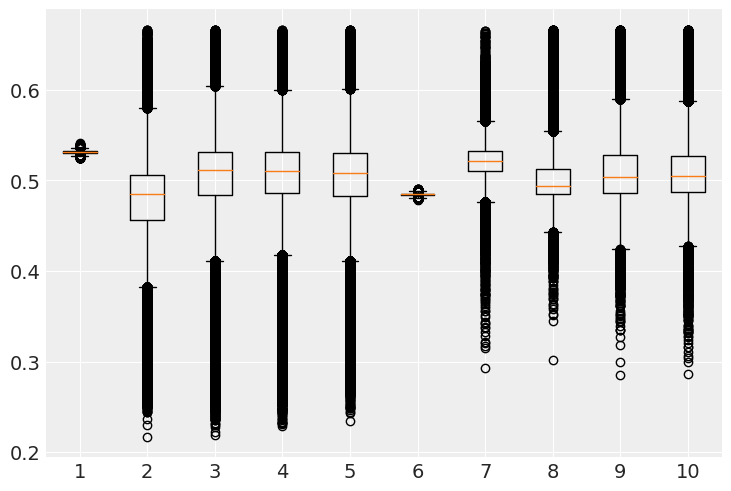

In [202]:
plt.boxplot([normalized_reg[...,0],
             normalized_reg[...,1],
             normalized_reg[...,2],
             normalized_reg[...,3],
             normalized_reg[...,4],
             normalized_reg[...,5],
             normalized_reg[...,6],
             normalized_reg[...,7],
             normalized_reg[...,8],
             normalized_reg[...,9]]);
            

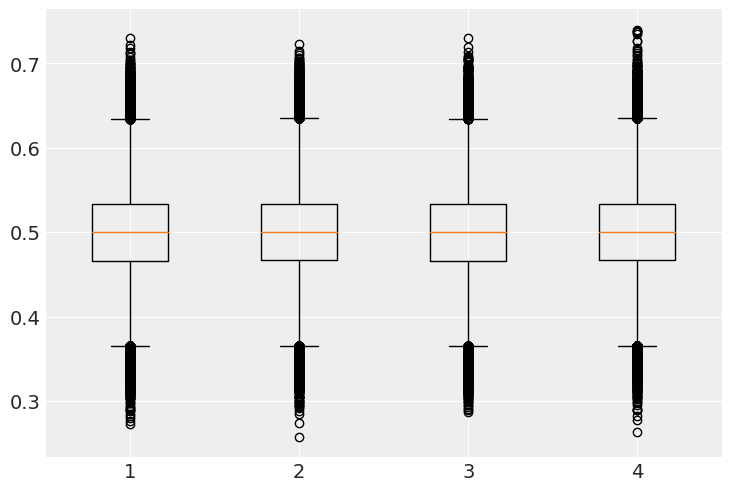

In [203]:
plt.boxplot([normalized_p[...,0],normalized_p[...,1],normalized_p[...,2],normalized_p[...,3]]);

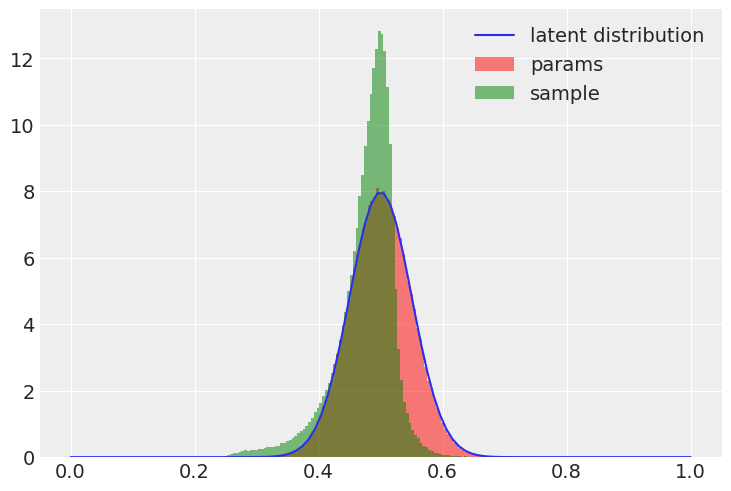

In [204]:
dist = tfd.Normal(0.5,0.05)
axe = jnp.linspace(0,1,100)
plt.plot(axe,dist.prob(axe),label='latent distribution')
plt.hist(normalized_p[...,0],100,color='r',density=True,alpha=0.5,label='params');
plt.hist(normalized_reg[...,1],100,color='g',alpha=0.5,density=True,label='sample');
plt.legend()

In [205]:
# create data stream
batch_size = 1000
ntrain = len(batch)
num_batches = ntrain // batch_size 

def data_stream():
  """
  Creates a data stream with a predifined batch size.
  """
  rng = np.random.RandomState(0)
  while True:
    perm = rng.permutation(ntrain)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size: (i + 1)*batch_size]
      yield normalized_reg[batch_idx], mu[batch_idx], score[batch_idx]

batches = data_stream()

In [206]:
from functools import partial

In [353]:
bijector = partial(AffineSigmoidCoupling, 
                   layers = [256,256,256,256,256],
                   n_components = 64, 
                   activation = jax.nn.silu)

NF = partial(ConditionalRealNVP, n_layers = 4, bijector_fn = bijector)

nvp_nd = hk.without_apply_rng(hk.transform(lambda p,x : NF(4)(x).log_prob(p).squeeze()))
nvp_sample_nd = hk.transform(lambda x : NF(4)(x).sample(10000, seed=hk.next_rng_key()))
transformed_log_prob = hk.without_apply_rng(hk.transform(
    lambda p,x:tfd.TransformedDistribution(NF(4)(x), 
                                           tfb.Invert(transformation_params)).log_prob(p)))

In [ ]:
rng_seq = hk.PRNGSequence(5)
params_nd = transformed_log_prob.init(next(rng_seq),  0.5*jnp.ones([1,4]), 0.5*jnp.ones([1,10]))

In [355]:
scheduler = optax.exponential_decay(init_value=0.0005, transition_steps=2000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
opt_state = optimizer.init(params_nd)

In [356]:
from tqdm import tqdm

In [357]:
def loss_fn(params, weight, mu, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda theta, x: transformed_log_prob.apply(params, theta.reshape([1,4]), x.reshape([1,10])).squeeze()))(mu, batch)
  return -jnp.mean(log_prob) + weight * jnp.mean(jnp.sum((out - score)**2, axis=1)) 


@jax.jit
def update(params, opt_state, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [370]:
  # train 
  losses = []
  num_epochs = 30
  weight = 0 
  
  for epochs in tqdm(range(num_epochs)):
    for _ in range(num_batches):
      b,m,s = next(batches)    
      l, params_nd, opt_state = update(params_nd, opt_state,weight, m,  b, s)
      losses.append(l)

      if jnp.isnan(l)==True:
        print('NAN')
        break

      params_nd_t = params_nd

    if jnp.isnan(l)==True:
      print('NAN')
      break    

100%|██████████| 30/30 [10:10<00:00, 20.36s/it]


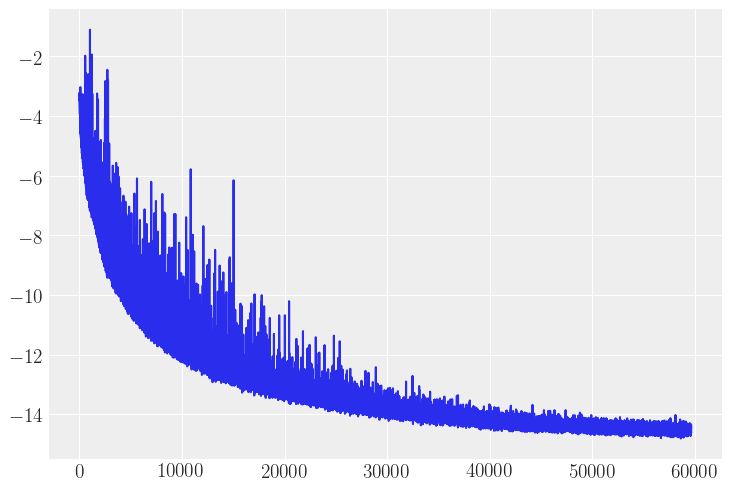

In [371]:
plt.plot(losses)

In [342]:
losses[-1]

DeviceArray(-11.644777, dtype=float32)

In [228]:
test_samples_fixed=jnp.load('/content/posterior_z_fixedkey0-4.npy')

In [ ]:
#nvp_sample_nd = hk.transform(lambda x : NF(4)(x).sample(int(1e4), seed=hk.next_rng_key()))
#sample_nd = nvp_sample_nd.apply(params_nd, rng = next(rng_seq), x = transformation_x.inverse(observation)*jnp.ones([int(1e4),10]))

In [ ]:
transformed_sample = hk.transform(
    lambda x:tfd.TransformedDistribution(NF(4)(x), 
                                           tfb.Invert(transformation_params)).sample(10000, seed=hk.next_rng_key()))
sample_nd = transformed_sample.apply(params_nd, rng = next(rng_seq), x = transformation_x.forward(observation)*jnp.ones([int(1e4),10]))

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


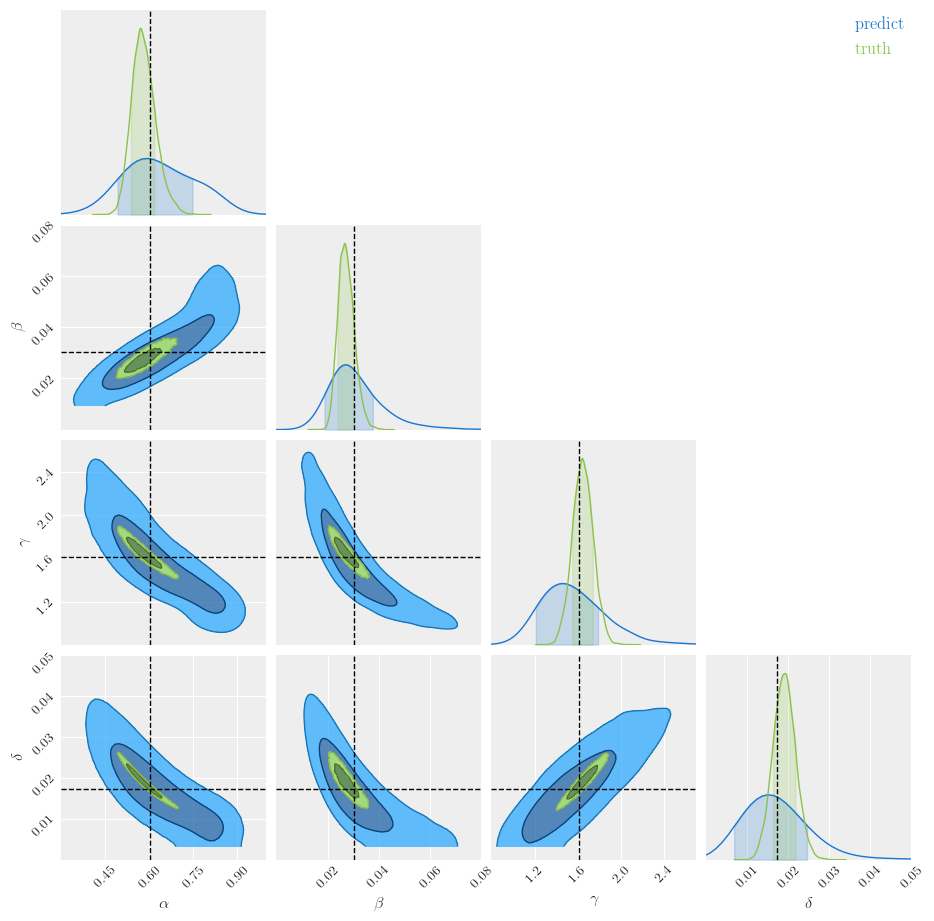

In [375]:
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()

c.add_chain(sample_nd, parameters=parameters, name="predict")
c.add_chain(test_samples_fixed, parameters=parameters, name="truth")
fig = c.plotter.plot(figsize=[10,10], 
                     truth=[0.603503  , 0.03026864, 1.6093055 , 0.01722082],
                     extents={r'$\alpha$': (0.3,1),
                              r'$\beta$':(0,0.08),
                              r'$\gamma$':(0.8,2.7),
                              r'$\delta$':(0,0.05),})


In [376]:
from sbids.metrics.c2st import c2st

In [377]:
metric = c2st(sample_nd,test_samples_fixed,0,5)

In [378]:
metric

array(0.94315, dtype=float32)